# Ultimate Technologies Inc. Take-Home Challenge

Ultimate Technologies Inc. is a transportation network company that has disrupted the taxi and logistics industry and is considered a prestigious company to work for. This challenge has been adapted from an actual Ultimate Inc. data science challenge.

## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

### Imports

In [1]:
import pandas as pd
import numpy as np
import json
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7.5)

### EDA

In [2]:
df = pd.read_json(path_or_buf='raw_data/logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
print('DF Summary:', df.describe())

DF Summary:                  login_time
count                 93142
unique                92265
top     1970-03-17 01:01:39
freq                      3
first   1970-01-01 20:12:16
last    1970-04-13 18:57:38


In [4]:
print('Type:', df.dtypes)

Type: login_time    datetime64[ns]
dtype: object


In [5]:
# Convert login_time series to datetime
df['login_time'] = pd.to_datetime(df['login_time'])
print(df['login_time'].dtypes)

datetime64[ns]


In [6]:
# Set, sort, and resample index to login_time
df = df.set_index('login_time').sort_index().resample('15T').size()

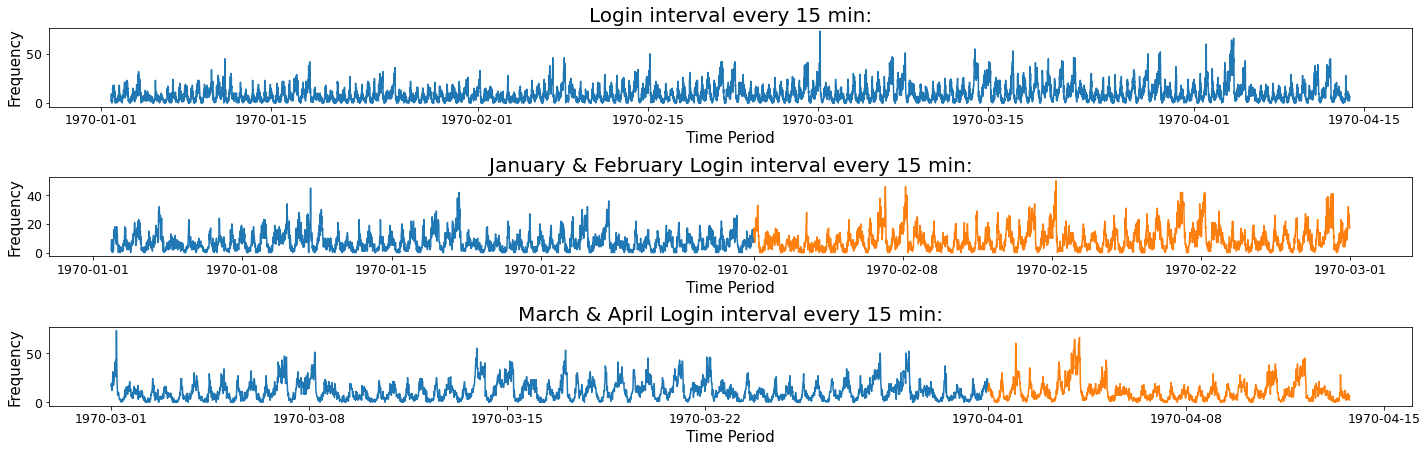

In [7]:
# Visualize data
plt.figure(figsize=(20,10))

plt.subplot(5,1,1)
plt.plot(df)
plt.title('Login interval every 15 min:', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5,1,2)
plt.plot(df.loc['1970-01-01':'1970-01-31'])
plt.title('January & February Login interval every 15 min:', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)


plt.subplot(5, 1, 2)
plt.plot(df.loc['1970-02-01':'1970-02-28'])
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5, 1, 3)
plt.plot(df.loc['1970-03-01':'1970-03-31'])
plt.title('March & April Login interval every 15 min:', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5, 1, 3)
plt.plot(df.loc['1970-04-01':'1970-04-30'])
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.tight_layout()
plt.show()

According to the visualizations, above the busiest month of the year is February due to a higher login average for the entire month than others. April is second as the busiet month of the year.

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The key measure of success for this experiment would be the revenue produced by both cities. This would mean demand or toll fees paid for, times the amount of money for each toll per city. Drivers can be encouraged to drive both cities by charging a higher fee during the high demand times for each city and simultaneously charging a lower fee for times there is less traffic.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment?

First I would analyze the riders that have at least 2+ rides in the last 30 days, controlling for outliers or recognizing factors that may skew results. Second, compare the cities that are showing the most riders and with the specific times these riders are booking rides. Third, compare the times with the avg_surge and see if there is a correlation between the two.

b. what statistical test(s) you will conduct to verify the significance of the observation?

Based on the assumptions that the data is clean and has been wrangled properly, I can use traditional statistical tools to compare the two cities. By using the means of both cities and their riders, average time can be used to find peak times which can be correlated with each other and their confidence levels/significance levels. This can then be used to find the avg_surge percentile.

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats?

Based on the results I have scientifically analyzed, I would start my test by reimbursing the tolls that have been raised at a higher rate at peak times and review that action/result with the partners. After reviewing those results, we can do the same with other times that are not as popular or busy. Another starting point would be to track holidays and weekends since the popularity is high in both cities and could help return results faster.

***Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2***

# Part 3 ‐ Predictive modeling

### Imports

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier 

### EDA

In [9]:
# Convert json file to dataframe
with open('raw_data/ultimate_data_challenge.json', 'r') as file:
    data = json.load(file)
    
df2 = pd.DataFrame(data)
df2.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [10]:
# Review data objects
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [11]:
# Convert last_trip_date to a datetime type
df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'])
df2.dtypes

city                              object
trips_in_first_30_days             int64
signup_date                       object
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [12]:
# Create dataframe where trips_in_first_30_days are filtered to > 0
retained = df2[df2['trips_in_first_30_days'] != 0]
retained.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34610 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    34610 non-null  object        
 1   trips_in_first_30_days  34610 non-null  int64         
 2   signup_date             34610 non-null  object        
 3   avg_rating_of_driver    30237 non-null  float64       
 4   avg_surge               34610 non-null  float64       
 5   last_trip_date          34610 non-null  datetime64[ns]
 6   phone                   34292 non-null  object        
 7   surge_pct               34610 non-null  float64       
 8   ultimate_black_user     34610 non-null  bool          
 9   weekday_pct             34610 non-null  float64       
 10  avg_dist                34610 non-null  float64       
 11  avg_rating_by_driver    34503 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(6), int

In [13]:
print('Retained users with more than 0 trips in the first 30 days:', (len(retained)/len(df2))*100, '%')

Retained users with more than 0 trips in the first 30 days: 69.22 %


As a result of filtering the original total amount of users, aproximately 69% observed users were retained

### Build Predictive Model

In [14]:
# Convert last_trip_date to a datetime type
retained['signup_date'] = pd.to_datetime(retained['signup_date'])
retained['active'] = np.where(((retained['last_trip_date'] - retained['signup_date']) / np.timedelta64(1, 'M')) > 5, 1, 0)
print(retained.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34610 entries, 0 to 49998
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    34610 non-null  object        
 1   trips_in_first_30_days  34610 non-null  int64         
 2   signup_date             34610 non-null  datetime64[ns]
 3   avg_rating_of_driver    30237 non-null  float64       
 4   avg_surge               34610 non-null  float64       
 5   last_trip_date          34610 non-null  datetime64[ns]
 6   phone                   34292 non-null  object        
 7   surge_pct               34610 non-null  float64       
 8   ultimate_black_user     34610 non-null  bool          
 9   weekday_pct             34610 non-null  float64       
 10  avg_dist                34610 non-null  float64       
 11  avg_rating_by_driver    34503 non-null  float64       
 12  active                  34610 non-null  int64 

In [15]:
active_users = retained[retained['active']==1]
active_users.info()
print('Active users: ', (len(active_users)/len(retained))*100, '%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8121 entries, 3 to 49993
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    8121 non-null   object        
 1   trips_in_first_30_days  8121 non-null   int64         
 2   signup_date             8121 non-null   datetime64[ns]
 3   avg_rating_of_driver    7868 non-null   float64       
 4   avg_surge               8121 non-null   float64       
 5   last_trip_date          8121 non-null   datetime64[ns]
 6   phone                   8067 non-null   object        
 7   surge_pct               8121 non-null   float64       
 8   ultimate_black_user     8121 non-null   bool          
 9   weekday_pct             8121 non-null   float64       
 10  avg_dist                8121 non-null   float64       
 11  avg_rating_by_driver    8120 non-null   float64       
 12  active                  8121 non-null   int64  

In [16]:
print('Active users: ', (len(active_users)/len(retained))*100, '%')

Active users:  23.46431667148223 %


In [17]:
# Convert ultimate_black_user to binary
retained['ultimate_black_user'] = retained['ultimate_black_user'].astype(int)
retained.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,1,100.0,10.56,5.0,0


In [18]:
# Drop all nas
retained['phone'] = retained['phone'].fillna('Other')
retained.dropna(inplace=True)
retained.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30158 entries, 0 to 49998
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    30158 non-null  object        
 1   trips_in_first_30_days  30158 non-null  int64         
 2   signup_date             30158 non-null  datetime64[ns]
 3   avg_rating_of_driver    30158 non-null  float64       
 4   avg_surge               30158 non-null  float64       
 5   last_trip_date          30158 non-null  datetime64[ns]
 6   phone                   30158 non-null  object        
 7   surge_pct               30158 non-null  float64       
 8   ultimate_black_user     30158 non-null  int64         
 9   weekday_pct             30158 non-null  float64       
 10  avg_dist                30158 non-null  float64       
 11  avg_rating_by_driver    30158 non-null  float64       
 12  active                  30158 non-null  int64 

In [19]:
# Get dummies and drop all non numerical features
retained = pd.get_dummies(retained)
retained.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
retained.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,0,0,1,0,0,0,1
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0,0
5,2,3.5,1.00,0.0,1,100.0,10.56,5.0,0,0,0,1,0,0,1


In [20]:
# Create X and y features for modeling
X = retained.drop(['active'], axis=1)
y = retained['active']
print(X.shape, y.shape)

(30158, 14) (30158,)


In [21]:
# Check all features are numerical
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30158 entries, 0 to 49998
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  30158 non-null  int64  
 1   avg_rating_of_driver    30158 non-null  float64
 2   avg_surge               30158 non-null  float64
 3   surge_pct               30158 non-null  float64
 4   ultimate_black_user     30158 non-null  int64  
 5   weekday_pct             30158 non-null  float64
 6   avg_dist                30158 non-null  float64
 7   avg_rating_by_driver    30158 non-null  float64
 8   city_Astapor            30158 non-null  uint8  
 9   city_King's Landing     30158 non-null  uint8  
 10  city_Winterfell         30158 non-null  uint8  
 11  phone_Android           30158 non-null  uint8  
 12  phone_Other             30158 non-null  uint8  
 13  phone_iPhone            30158 non-null  uint8  
dtypes: float64(6), int64(2), uint8(6)
memo

In [22]:
# Create function for building and plotting model
def train_test_model(X, y, model, params, test_size=.2, random_state=32):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model_cv = GridSearchCV(model, param_grid=params, cv=5)
    
    model_cv.fit(X_train, y_train)
    
    y_pred = model_cv.predict(X_test)
    
    y_pred_prob = model_cv.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();
    
    # Print the optimal parameters and best score
    print("Tuned Hyperparameter(s): {}".format(model_cv.best_params_))
    print("Tuned Accuracy Score: {}".format(model_cv.best_score_))
    print(classification_report(y_test, y_pred))

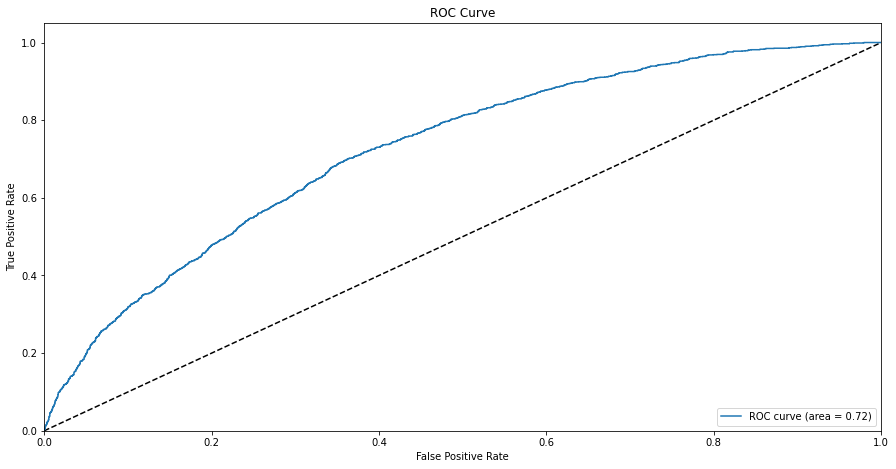

Tuned Hyperparameter(s): {'C': 143844.988828766, 'penalty': 'l2'}
Tuned Accuracy Score: 0.7538756433738666
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      4467
           1       0.58      0.21      0.30      1565

    accuracy                           0.76      6032
   macro avg       0.68      0.58      0.58      6032
weighted avg       0.72      0.76      0.71      6032



In [23]:
# Build model
logreg = LogisticRegression()
c_space = np.logspace(-10, 8, 20) # Covers a WIDE range of possinle C values
logreg_param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

train_test_model(X, y, logreg, logreg_param_grid)

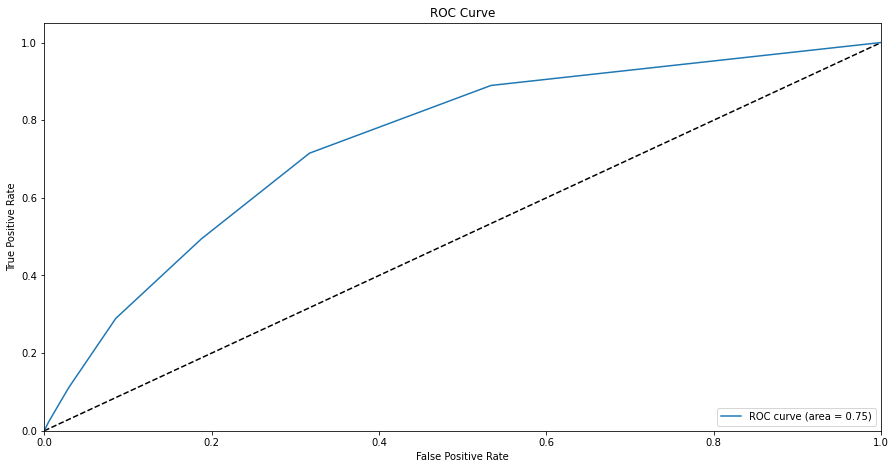

Tuned Hyperparameter(s): {'n_neighbors': 6}
Tuned Accuracy Score: 0.7523005138401878
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      4467
           1       0.54      0.29      0.38      1565

    accuracy                           0.75      6032
   macro avg       0.66      0.60      0.61      6032
weighted avg       0.72      0.75      0.72      6032



In [24]:
# Build K Neigbors model
knn = KNeighborsClassifier()
N = [1,2,3,4,5,6,7]
knn_param_grid = {'n_neighbors': N}
train_test_model(X, y, knn, knn_param_grid)

In [ ]:
# Build Random Forest model
forest = RandomForestClassifier()
forest_param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": range(10,500,20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
train_test_model(X, y, forest, forest_param_grid)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=32)

best_model = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, max_features=3, min_samples_split=250)
best_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features=3, min_samples_split=250)

In [27]:
# Explore feature importances
features = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
features

,importance
avg_rating_by_driver,0.209023
surge_pct,0.197656
weekday_pct,0.132073
avg_surge,0.119728
ultimate_black_user,0.063933
avg_rating_of_driver,0.055449
phone_iPhone,0.044485
city_King's Landing,0.038950
phone_Android,0.038681
trips_in_first_30_days,0.036681


### Plot several discussion points on users

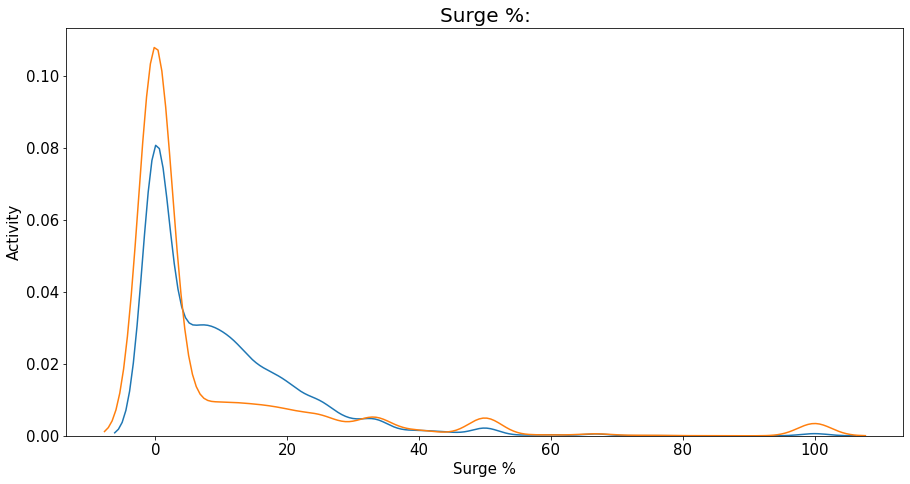

In [28]:
non_active_users = retained[retained['active']==0]

sns.distplot(active_users['surge_pct'], hist=False, kde_kws={"label": "Active Users"});
sns.distplot(non_active_users['surge_pct'], hist=False, kde_kws={"label": "Non-Active Users"});
plt.title('Surge %:', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Surge %", size=15)
plt.ylabel('Activity', size=15)
plt.show()

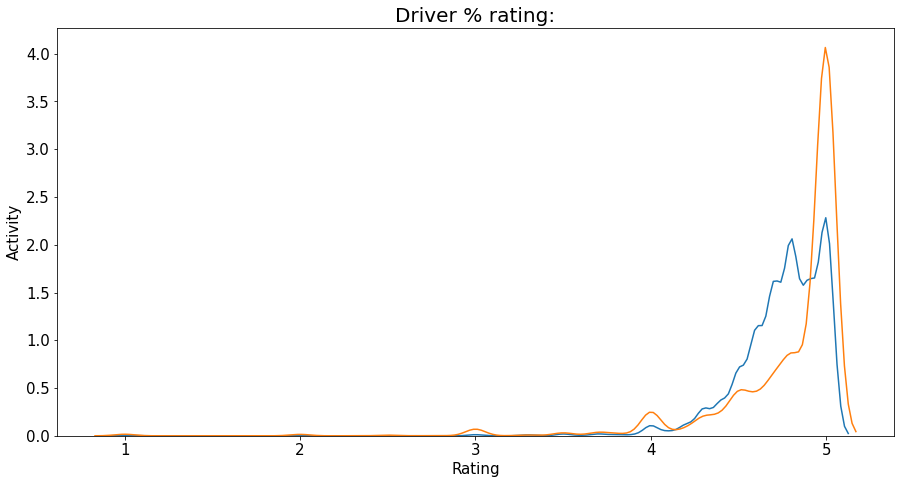

In [29]:
sns.distplot(active_users['avg_rating_by_driver'], hist=False, kde_kws={"label": "Active Users"});
sns.distplot(non_active_users['avg_rating_by_driver'], hist=False, kde_kws={"label": "Non-Active Users"});
plt.title('Driver % rating:', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Rating", size=15)
plt.ylabel('Activity', size=15)
plt.show()

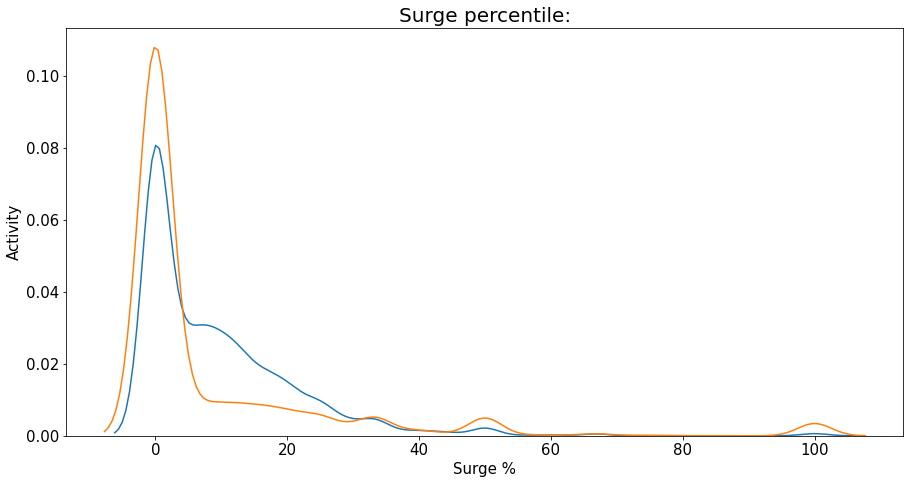

In [30]:
sns.distplot(active_users['surge_pct'], hist=False, kde_kws={"label": "Active Users"});
sns.distplot(non_active_users['surge_pct'], hist=False, kde_kws={"label": "Non-Active Users"});
plt.title('Surge percentile:', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Surge %", size=15)
plt.ylabel('Activity', size=15)
plt.show()

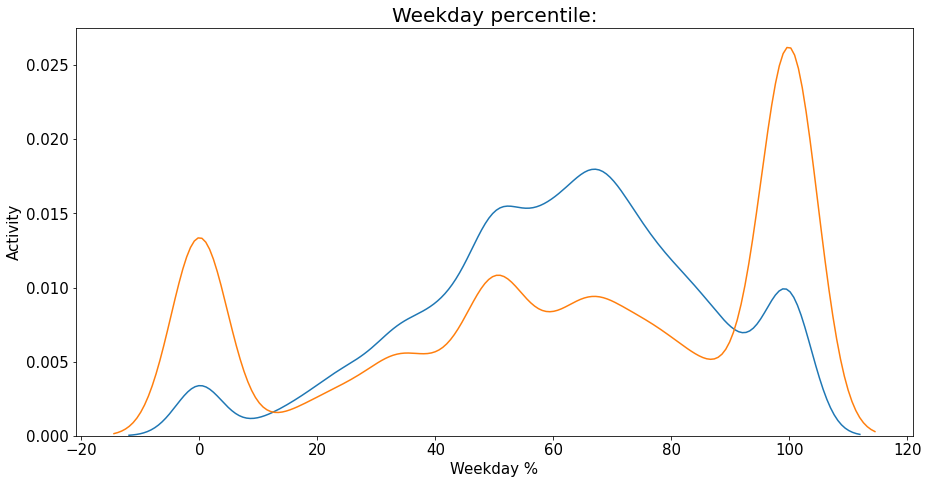

In [31]:
sns.distplot(active_users['weekday_pct'], hist=False, kde_kws={"label": "Active Users"});
sns.distplot(non_active_users['weekday_pct'], hist=False, kde_kws={"label": "Non-Active Users"});
plt.title('Weekday percentile:', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Weekday %", size=15)
plt.ylabel('Activity', size=15)
plt.show()

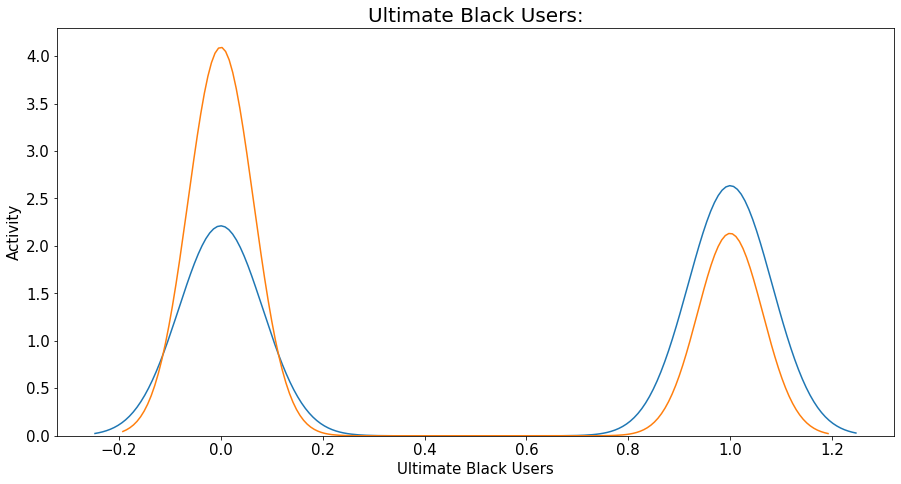

In [32]:
sns.distplot(active_users['ultimate_black_user'], hist=False, kde_kws={"label": "Active Users"});
sns.distplot(non_active_users['ultimate_black_user'], hist=False, kde_kws={"label": "Non-Active Users"});
plt.title('Ultimate Black Users:', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Ultimate Black Users", size=15)
plt.ylabel('Activity', size=15)
plt.show()